<a href="https://colab.research.google.com/github/gerardgoh/bt4222/blob/main/final_cleanedmetadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [72]:
import pandas as pd
import gzip
from google.colab import drive
drive.mount('/content/drive/')
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Reading The File

In [74]:
file_path = "/content/drive/MyDrive/meta_Electronics.json.gz"

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(file_path)

# Basic Data Understanding

### Overall Structure

In [75]:
df.head()

,asin,imUrl,description,categories,title,price,salesRank,related,brand
0,0132793040,http://ecx.images-amazon.com/images/I/31JIPhp%...,The Kelby Training DVD Mastering Blend Modes i...,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Mastering Blend Modes in A...,NaN,NaN,NaN,NaN
1,0321732944,http://ecx.images-amazon.com/images/I/31uogm6Y...,NaN,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Adobe Photoshop CS5 Crash ...,NaN,NaN,NaN,NaN
2,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN
3,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[[Electronics, Accessories & Supplies, Audio &...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN
4,0528881469,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


The features "categories", "salesRank", and "related" may need further preprocessing to unpack the values inside

In [76]:
df.shape

(498196, 9)

### Checking for Empty Values

In [77]:
df.isnull().sum()

,0
asin,0
imUrl,175
description,38726
categories,0
title,7002
price,108503
salesRank,369490
related,131237
brand,355664


In [78]:
round(df.isnull().sum() / len(df) * 100, 2)

,0
asin,0.00
imUrl,0.04
description,7.77
categories,0.00
title,1.41
price,21.78
salesRank,74.17
related,26.34
brand,71.39


Large percentages of the data in salesRank and brand are related

In [79]:
df.describe()

,price
count,389693.000000
mean,61.406786
std,119.118870
min,0.010000
25%,9.950000
50%,19.990000
75%,51.950000
max,999.990000


## Exploring Specific Features

### Exploring "Category"

In [80]:
df["categories"][5]

[['Electronics',
  'Accessories & Supplies',
  'Audio & Video Accessories',
  'Headphones']]

The feature category seems to have a hierarchical ordering (broad -> most granular)


We will puruse the following steps:
- Flatten out the categories to form one hierarchical chain
- Extract the most granular category

In [82]:
def flatten_categories(categories):
    """
    Flattens the hierarchical category lists to a flattened string representation
    """
    if not categories:
        return ""

    # If the first element is a list, assume multiple category paths
    if isinstance(categories[0], list):
        flattened_paths = [" > ".join(path) for path in categories]
        # Join multiple paths with a semicolon for clarity
        return "; ".join(flattened_paths)
    else:
        # Otherwise, join the single list into a string
        return " ".join(categories)

In [83]:
df["flattened_categories"] = df["categories"].apply(flatten_categories)

In [84]:
df["flattened_categories"][0]

'Electronics > Computers & Accessories > Cables & Accessories > Monitor Accessories'

In [85]:
df['granular_category'] = df['flattened_categories'].apply(lambda x: x.split(' > ')[-1] if isinstance(x, str) else np.nan)
df['first_category'] = df['flattened_categories'].apply(lambda x: x.split(' > ')[0] if isinstance(x, str) else np.nan)

We also see a reduction in the number of unique categories after extracting out the most granular one - potential to find similar products

In [86]:
df["flattened_categories"].nunique()

2470

In [87]:
df["granular_category"].nunique()

1000

### Discrepancy in Labelling for "Categories"

We identified a discrepancy in the category labels when the product had multiple labels.
Example: 'Hoodies' was classified under Electronics and Clothing when it should not be under Electronics. We removed all products with more than 1 category label.

Plotted a Pie Chart to visualise proportion of data with more than 1 category

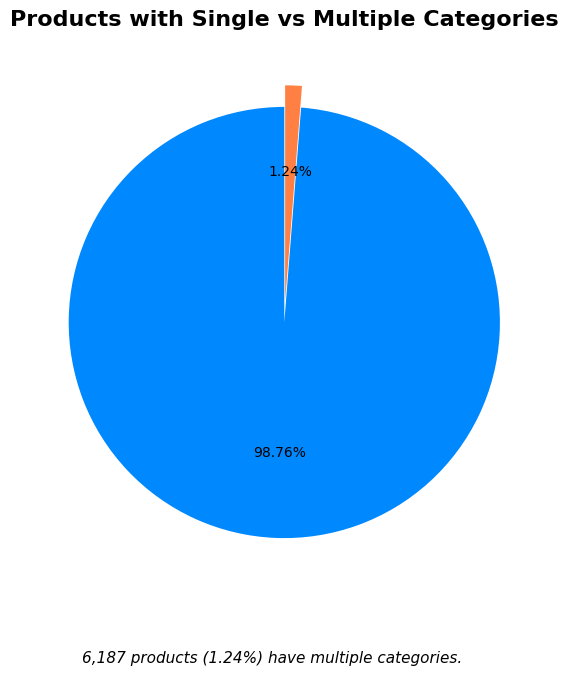

In [89]:
df["category_paths"] = df["flattened_categories"].str.split(";")
df["n_categories"] = df["category_paths"].apply(len)

# Group the data into single-category and multi-category products
df['category_group'] = df['n_categories'].apply(lambda x: 'Single category' if x == 1 else 'Multiple categories')

# Calculate counts for each group
grouped_counts = df['category_group'].value_counts()

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Define colors for the pie slices
colors = ['#0088FE', '#FF8042']

# Create the pie chart
wedges, texts, autotexts = ax.pie(
    grouped_counts,
    labels=None,  # We'll add custom labels
    autopct='%1.2f%%',
    startangle=90,
    colors=colors,
    explode=(0, 0.1)  # Slightly explode the 'Multiple categories' slice for emphasis
)

# Add title
plt.title('Products with Single vs Multiple Categories', fontsize=16, fontweight='bold', pad=20)

# Add a note about multi-category products
multi_count = grouped_counts.get('Multiple categories', 0)
total_count = grouped_counts.sum()
multi_percent = (multi_count / total_count) * 100

plt.figtext(
    0.5, 0.01,
    f"{multi_count:,} products ({multi_percent:.2f}%) have multiple categories.",
    ha="center", fontsize=11, style='italic'
)
# Save the figure
plt.savefig('single_vs_multiple_categories.png', dpi=300, bbox_inches='tight')

# Display the figure
plt.show()

Finding the number of products with more than 1 category label, separated by a ; in `flattened_categories`

In [90]:
# flag products with more than 1 category
df_multi = df[df["n_categories"] > 1]
len(df_multi)
df_multi.head()

,asin,imUrl,description,categories,title,price,salesRank,related,brand,flattened_categories,granular_category,first_category,category_paths,n_categories,category_group
48,1182702627,http://ecx.images-amazon.com/images/I/41nqaKca...,Color: As the pictures show. (may be a little...,"[[Cell Phones & Accessories, Cases, Basic Case...",Hello Kitty Home Button Sticker plus Free Scre...,1.80,{'Cell Phones & Accessories': 340563},"{'also_bought': ['B008GYZSEA', 'B00979II6S', '...",NaN,Cell Phones & Accessories > Cases > Basic Case...,Screen Protectors,Cell Phones & Accessories,[Cell Phones & Accessories > Cases > Basic Cas...,2,Multiple categories
189,6301977173,http://ecx.images-amazon.com/images/I/21J51BBX...,Tom Sawyer VHS Movie,"[[Electronics, Accessories & Supplies, Blank M...",Tom Sawyer [VHS],2.99,{'Movies & TV': 187149},"{'also_bought': ['6302945127', 'B00005TPMM', '...",NaN,Electronics > Accessories & Supplies > Blank M...,Movies,Electronics,[Electronics > Accessories & Supplies > Blank ...,3,Multiple categories
202,7108037661,http://ecx.images-amazon.com/images/I/21cxivyH...,Works on all capacitive touch surfaces; use wi...,"[[Cell Phones & Accessories, Accessories, Styl...",Case Square Premium Quality Red Stylus for iPh...,2.80,{'Cell Phones & Accessories': 422293},"{'also_bought': ['9862720530', '9621446805', '...",NaN,Cell Phones & Accessories > Accessories > Styl...,Cases & Sleeves,Cell Phones & Accessories,[Cell Phones & Accessories > Accessories > Sty...,3,Multiple categories
265,8862935293,http://ecx.images-amazon.com/images/I/517d128j...,California residents:Click herefor Proposition...,"[[Electronics, Computers & Accessories, Touch ...",NaN,69.00,NaN,"{'also_viewed': ['8862936850', 'B008MF465K', '...",NaN,Electronics > Computers & Accessories > Touch ...,Covers,Electronics,[Electronics > Computers & Accessories > Touch...,2,Multiple categories
267,8862935307,http://ecx.images-amazon.com/images/I/418D0zFK...,California residents:Click herefor Proposition...,"[[Electronics, Computers & Accessories, Touch ...",NaN,9.99,NaN,"{'also_viewed': ['B002Y27P6Y', 'B006TG7KWU', '...",NaN,Electronics > Computers & Accessories > Touch ...,Sleeves,Electronics,[Electronics > Computers & Accessories > Touch...,3,Multiple categories


In [91]:
df[df['granular_category'] == "Hoodies"]

,asin,imUrl,description,categories,title,price,salesRank,related,brand,flattened_categories,granular_category,first_category,category_paths,n_categories,category_group
464945,B00FG3SE54,http://ecx.images-amazon.com/images/I/41SuXku0...,NaN,"[[Electronics, Accessories & Supplies, Audio &...",Breaking Bad - Los Pollos Hermanos Zip Hoodie ...,NaN,{'Clothing': 97982},"{'also_bought': ['B00FG3FIXU', 'B00DQW5NU6', '...",NaN,Electronics > Accessories & Supplies > Audio &...,Hoodies,Electronics,[Electronics > Accessories & Supplies > Audio ...,2,Multiple categories
464947,B00FG3SE9K,http://ecx.images-amazon.com/images/I/41SuXku0...,NaN,"[[Electronics, Accessories & Supplies, Audio &...",Breaking Bad - Los Pollos Hermanos Zip Hoodie ...,NaN,{'Clothing': 97982},"{'also_bought': ['B00FG3FIXU', 'B00DQW5NU6', '...",NaN,Electronics > Accessories & Supplies > Audio &...,Hoodies,Electronics,[Electronics > Accessories & Supplies > Audio ...,2,Multiple categories
464951,B00FG3SEDG,http://ecx.images-amazon.com/images/I/41SuXku0...,NaN,"[[Electronics, Accessories & Supplies, Audio &...",Breaking Bad - Los Pollos Hermanos Zip Hoodie ...,NaN,{'Clothing': 97982},"{'also_bought': ['B00FG3FIXU', 'B00DQW5NU6', '...",NaN,Electronics > Accessories & Supplies > Audio &...,Hoodies,Electronics,[Electronics > Accessories & Supplies > Audio ...,2,Multiple categories


dropping those where `n_categories`> 1

In [92]:
df = df[df['n_categories'] <= 1]
df

,asin,imUrl,description,categories,title,price,salesRank,related,brand,flattened_categories,granular_category,first_category,category_paths,n_categories,category_group
0,0132793040,http://ecx.images-amazon.com/images/I/31JIPhp%...,The Kelby Training DVD Mastering Blend Modes i...,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Mastering Blend Modes in A...,NaN,NaN,NaN,NaN,Electronics > Computers & Accessories > Cables...,Monitor Accessories,Electronics,[Electronics > Computers & Accessories > Cable...,1,Single category
1,0321732944,http://ecx.images-amazon.com/images/I/31uogm6Y...,NaN,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Adobe Photoshop CS5 Crash ...,NaN,NaN,NaN,NaN,Electronics > Computers & Accessories > Cables...,Monitor Accessories,Electronics,[Electronics > Computers & Accessories > Cable...,1,Single category
2,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN,"Electronics > Computers & Accessories > PDAs, ...",PDAs & Handhelds,Electronics,"[Electronics > Computers & Accessories > PDAs,...",1,Single category
3,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[[Electronics, Accessories & Supplies, Audio &...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN,Electronics > Accessories & Supplies > Audio &...,TV Remote Controls,Electronics,[Electronics > Accessories & Supplies > Audio ...,1,Single category
4,0528881469,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN,Electronics > GPS & Navigation > Vehicle GPS >...,Trucking GPS,Electronics,[Electronics > GPS & Navigation > Vehicle GPS ...,1,Single category
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498191,BT008V9J9U,http://ecx.images-amazon.com/images/I/313e6SJm...,Vehicle suction cup mount (replacement) NOTICE...,"[[Electronics, GPS & Navigation, GPS System Ac...",Suction Cup Mount,21.99,NaN,{'buy_after_viewing': ['B000EPFCC2']},Garmin,Electronics > GPS & Navigation > GPS System Ac...,Vehicle Mounts,Electronics,[Electronics > GPS & Navigation > GPS System A...,1,Single category
498192,BT008SXQ4C,http://ecx.images-amazon.com/images/I/31oF9oNv...,Quatech - 1 Port PCMCIA to DB-25 Parallel Adap...,"[[Electronics, Computers & Accessories, Cables...",Parallel PCMCIA Card 1PORT Epp,23.99,NaN,"{'also_bought': ['B000SR2H4W', 'B001Q7X0W6'], ...",NaN,Electronics > Computers & Accessories > Cables...,Serial Cables,Electronics,[Electronics > Computers & Accessories > Cable...,1,Single category
498193,BT008G3W52,http://ecx.images-amazon.com/images/I/21WIrX5f...,C2G - 5m Ultma USB 2.0 A Mini B Cble,"[[Electronics, Computers & Accessories, Cables...",C2G / Cables to Go 5M Ultima USB 2.0 Cable,18.91,NaN,"{'bought_together': ['B0002D6QJO'], 'buy_after...",C2G,Electronics > Computers & Accessories > Cables...,USB Cables,Electronics,[Electronics > Computers & Accessories > Cable...,1,Single category
498194,BT008UKTMW,http://ecx.images-amazon.com/images/I/41TNAVmf...,Keyboard drawer.,"[[Electronics, Computers & Accessories, Cables...",Underdesk Keyboard Drawer,25.54,NaN,"{'also_viewed': ['B0002LD0ZY', 'B0002LCZP0', '...",Fellowes,Electronics > Computers & Accessories > Cables...,Keyboards,Electronics,[Electronics > Computers & Accessories > Cable...,1,Single category


### Exploring "related"

For related:
- Separate out the nested dictionary into "also_viewed", "also_bought", "bought_together", "buy_after_viewing" to be individual features

In [93]:
df['also_viewed'] = df['related'].apply(lambda x: list(set(x.get('also_viewed', []))) if isinstance(x, dict) else [])
df['also_bought'] = df['related'].apply(lambda x: list(set(x.get('also_bought', []))) if isinstance(x, dict) else [])
df['bought_together'] = df['related'].apply(lambda x: list(set(x.get('bought_together', []))) if isinstance(x, dict) else [])
df['buy_after_viewing'] = df['related'].apply(lambda x: list(set(x.get('buy_after_viewing', []))) if isinstance(x, dict) else [])

In [94]:
related_features = ["also_viewed", "also_bought", "buy_after_viewing", "bought_together"]

def calculate_missing_feature_percentages(related_features):
    for feature in related_features:
        missing_pct = round(df[feature].apply(lambda x: len(x) == 0).mean() * 100, 2)
        print(f"{feature} is missing: {missing_pct}%")
    return

calculate_missing_feature_percentages(related_features)

also_viewed is missing: 61.7%
also_bought is missing: 71.74%
buy_after_viewing is missing: 36.25%
bought_together is missing: 71.88%


### Exploring "Price"

In [95]:
def generate_price_histogram(df, bins=50, zoom_max=None, title="Price Distribution"):
    plt.figure(figsize=(6, 4))
    sns.histplot(df['price'], bins=bins, kde=True, color='teal')
    median_price = df['price'].median()
    plt.axvline(median_price, color='red', linestyle='--', label=f"Median = ${median_price:.2f}")

    plt.title(title, fontsize=14)
    plt.xlabel("Price ($)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

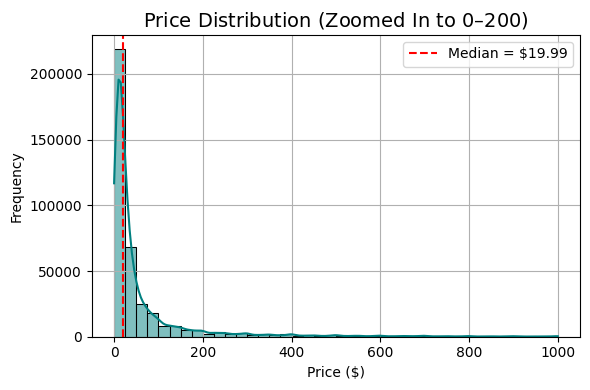

In [96]:
generate_price_histogram(df, bins=40, zoom_max=200, title="Price Distribution (Zoomed In to $0–$200)")

The distribution of product prices is heavily right-skewed, with most items priced below $200. The median price is much lower than the mean, indicating the presence of high-value outliers.

### Deciding How to Impute Price

We first check whether prices are stable enough within each granular category to use category medians for imputation.


In [97]:
price_stats = df.groupby('granular_category')['price'].agg(['count', 'median', 'std']).sort_values(by='std', ascending=False)
price_stats.head(8)  # or however many rows you want

,count,median,std
granular_category,,,
Subwoofer Kits,3,149.000,406.045945
VTR Decks,15,298.000,390.070595
Digital SLR Cameras,416,478.450,337.003334
Digital SLR Camera Bundles,860,403.540,332.799523
Stamp Creation Systems,8,10.260,326.205598
Aircraft Avionics,14,347.035,323.114721
Video Studio,6,66.805,317.828745
Motor Drives,8,104.970,313.321983


- Some granular categories have **very high price standard deviations**, indicating wide variability.

Due to high variance in both granular and flattened categories, we cannot rely solely on any one level for imputation. Instead, we'll use a **tiered strategy**:
1. For products with missing prices, we first attempted to use the median price from the same granular_category (the most specific category level)
2. If the product was the only item in its granular_category, we defaulted to the global median price (~$19) as a safe estimate

High priced items, particularly for electronics are real and important products, so we decided not to remove them, and instead use median for imputation as the last fallback as it is robust to outliers

### Implementing Tiered Price Imputation


In [98]:
# Create impute_source column if it doesn't exist
if 'impute_source' not in df.columns:
    df['impute_source'] = None
else:
    df['impute_source'] = None  # Reset existing column

# Calculate statistics once
granular_stats = df.groupby('granular_category')['price'].agg(['count', 'median', 'std'])
global_median = df['price'].median()  # Added global_median calculation

# Get missing price rows
missing_mask = df['price'].isna()

# For each granular category, impute its median price
for category in granular_stats.index:
    # Get rows with missing prices in this category
    category_mask = missing_mask & (df['granular_category'] == category)

    # If there's a valid median for this category (not NaN)
    if not pd.isna(granular_stats.loc[category, 'median']):
        # Impute with category median
        df.loc[category_mask, 'price'] = granular_stats.loc[category, 'median']
        df.loc[category_mask, 'impute_source'] = 'granular'

# For any remaining missing values (categories with no valid price data)
final_missing = df['price'].isna()
if final_missing.sum() > 0:
    df.loc[final_missing, 'price'] = global_median
    df.loc[final_missing, 'impute_source'] = 'global'

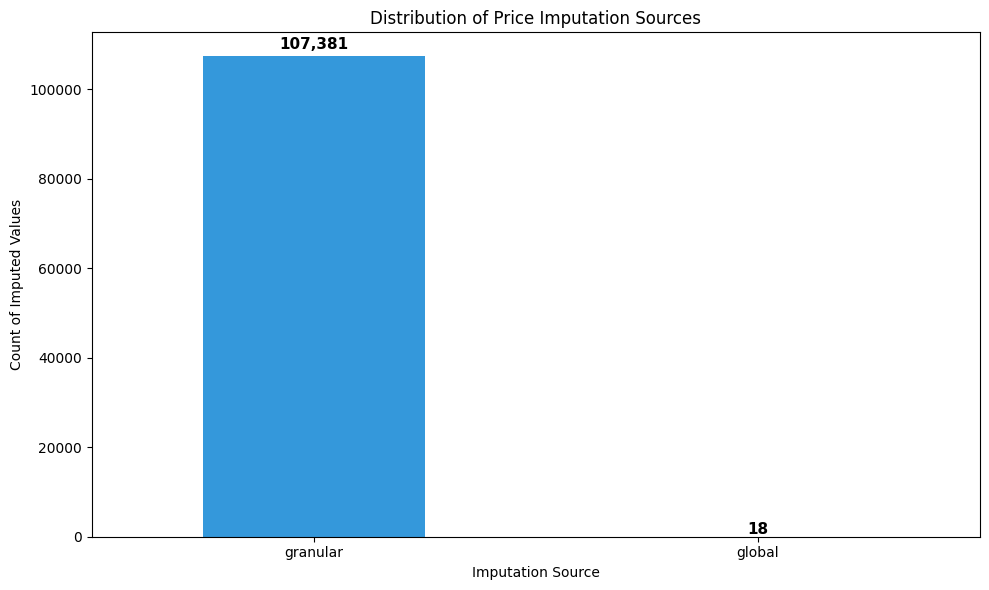

In [99]:
# 1. Distribution of imputation sources with count labels
plt.figure(figsize=(10, 6))
source_counts = df['impute_source'].value_counts(dropna=True)
ax = source_counts.plot(kind='bar', color=['#3498db', '#2ecc71', '#e74c3c'][:len(source_counts)])

# Add count labels on top of each bar
for i, count in enumerate(source_counts):
    ax.text(i, count + (count * 0.01), # Position slightly above bar
            f'{count:,}', # Format with commas for thousands
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='bold')

plt.title('Distribution of Price Imputation Sources')
plt.xlabel('Imputation Source')
plt.ylabel('Count of Imputed Values')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [100]:
print(f"Total missing price values: {df['price'].isna().sum()}")
print(f"Missing price values with missing granular category: {df[df['price'].isna()]['granular_category'].isna().sum()}")
print(f"Missing price values with missing flattened category: {df[df['price'].isna()]['flattened_categories'].isna().sum()}")

Total missing price values: 0
Missing price values with missing granular category: 0
Missing price values with missing flattened category: 0


### Exploring and Imputing Title and Description

From earlier, title and description are missing in 1.4% and 7.7% - a small minority

Hence, to prepare it for Sentence BERT processing, we fill it in with "no title" and "no description"

In [101]:
df['title'] = df['title'].fillna('[no title]')
df['description'] = df['description'].fillna('[no description]')


In [102]:
df.isnull().sum()

,0
asin,0
imUrl,142
description,0
categories,0
title,0
price,0
salesRank,367288
related,130086
brand,351052
flattened_categories,0


### Exporting metadata

The final cleaned metadata will be exported into csv format, as csv export converts all entries to strings, which can be used for Sentence-BERT embedding.

To preserve the original data types for processing of related items fallback model, we will also export the data to parquet form.

In [ ]:
df.to_csv("metadata_cleaned.csv", index=False, na_rep='NA')  # Explicitly represent NAs

In [ ]:
df.to_parquet('/content/drive/My Drive/amazon_data/metadata_cleaned.parquet')

In [ ]:
df.isnull().sum()

asin                         0
imUrl                      142
description                  0
categories                   0
title                        0
price                        0
salesRank               367288
related                 130086
brand                   351052
flattened_categories         0
granular_category            0
first_category               0
category_paths               0
n_categories                 0
also_viewed                  0
also_bought                  0
bought_together              0
buy_after_viewing            0
impute_source           384610
dtype: int64

Embedding

In [ ]:
def prepare_text(row):
    title = row['title']
    description = row['description']
    categories = row['flattened_categories']
    price = row['price']

    text = f"Title: {title}. Description: {description}. Categories: {categories}. Price: {price}"

df['text_data'] = df.apply(prepare_text, axis=1)

model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, fast, good quality

# Encode the combined text
product_embeddings = model.encode(
    df['text_data'].tolist(),
    show_progress_bar=True,
    batch_size=32,
    normalize_embeddings=True
)

# Now product_embeddings is a numpy array of shape (number of products, 384)
print("Embedding complete! Shape:", product_embeddings.shape)